# Representational similarity analysis

RSA quantifies the multivariate relationship between patterns of voxel activations associated with different experimental conditions or events. Although conceptually complex, the application is quite simple: correlating pairs of conditions to reveal a similarity (or distance) structure. This similarity structure can then be evaluated relative to representational hypothesis.

Performing RSA with nltools is straightforward, let's work through an example based on the beta maps for the different conditions that were estimated in the [first level tutorial](/2_glm_singlesubject.ipynb).

In [2]:
%matplotlib inline

import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import fdr, threshold, fisher_r_to_z, one_sample_permutation
from sklearn.metrics import pairwise_distances
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img_on_surf, view_img
from bids import BIDSLayout, BIDSValidator
import warnings
warnings.filterwarnings('ignore') 

data_dir = '/Users/michael/Dropbox/work/data/dartbrains/data/localizer'
layout = BIDSLayout(data_dir,derivatives=True)

We will first load in the 10 beta maps for a participant. Since pybids doesn't deal well with custom (i.e., non-fmriprep) files in the derivatives directory, we can grab them using glob. Note we are parsing through the file names to retrieve the condition labels.

In [3]:
subject = 'S01'
beta_files = glob(os.path.join(data_dir,'derivatives','pyglm',f'sub-{subject}','*beta.nii.gz'))
beta_files.sort()
conditions = [os.path.basename(x).split('-')[-1][5:-12] for x in beta_files]
beta = Brain_Data(beta_files)
conditions

['audio_computation',
 'audio_left_hand',
 'audio_right_hand',
 'audio_sentence',
 'horizontal_checkerboard',
 'vertical_checkerboard',
 'video_computation',
 'video_left_hand',
 'video_right_hand',
 'video_sentence']

RSA can be performed in many different ways, for example within just a few ROIs or across the whole brain using a searchlight approach. Here, we settle on an approach somewhere in the middle by using a whole brain parcellation that segments the brain into 50 distinct regions. This particular parcellation is based on Neurosynth data and is supposed to represent functional distinct brain regions.

Such a parcellation volume can be read in as a `Brain_Data` instance. There's a handy `expand_mask()` function that separates a labeled volume into label-specific volumes. We can see this below with the top plot showing all the labelled regions in the volume and the second plot showing just one of these regions.

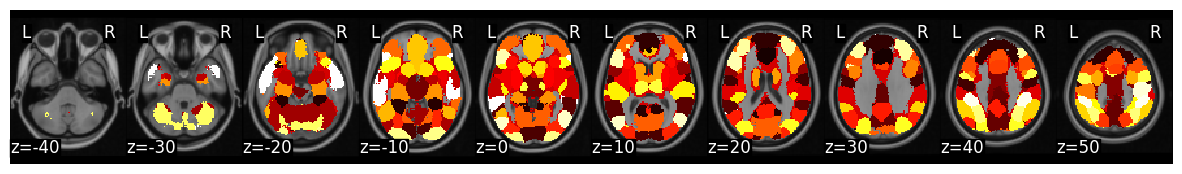

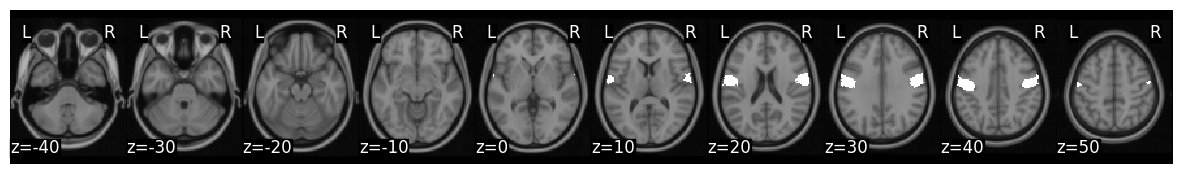

In [48]:
mask_file = 'NeurosynthParcellation50.nii.gz'
mask = Brain_Data(mask_file)
mask_x = expand_mask(mask) # separate different labels in mask into label-specific volumes
mask.plot()
mask_x[3].plot()

In [54]:
beta.apply_mask(mask_x[3]).iplot()
beta.apply_mask(mask_x[3])


interactive(children=(FloatText(value=0.0, description='Threshold'), IntSlider(value=0, continuous_update=Fals…

nltools.data.brain_data.Brain_Data(data=(10, 2949), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)

In [55]:
rsa = []
for m in mask_x:
    rsa.append(beta.apply_mask(m).distance(metric='correlation'))

The `.distance()` method returns an `Adjacency` instance, which is a [data structure from nltools](https://nltools.org/api.html?highlight=similarity#nltools.data.Adjacency). `Adjacency` instances represent distance or similarity matrices and have many attributes and methods. For example, you can switch between similarity and distances measures, plot them in various ways, and compare multiple `Adjacency` matrices. 

Let's look at the output from one specific region located in left motor cortex:

nltools.data.adjacency.Adjacency(shape=(45,), square_shape=(10, 10), Y=0, is_symmetric=True,matrix_type=distance)

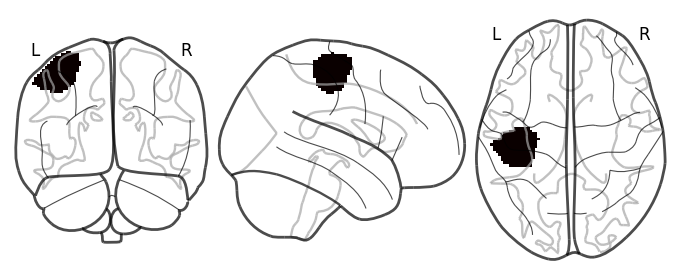

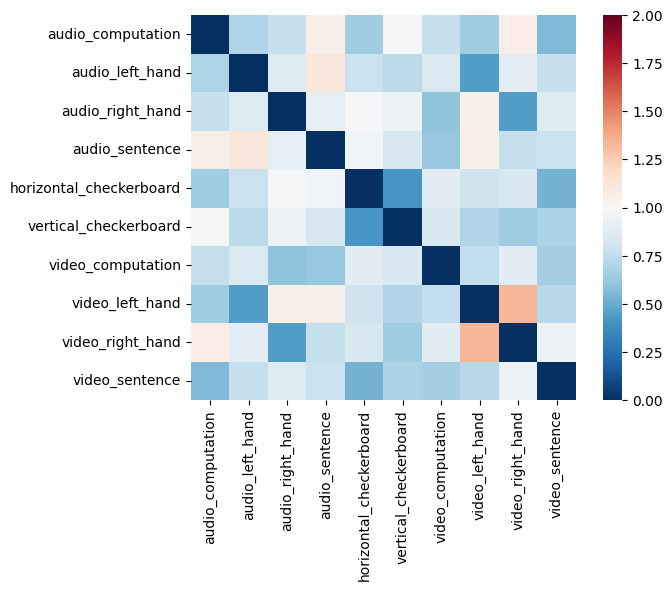

In [56]:
roi = 26
plot_glass_brain(mask_x[roi].to_nifti())
rsa[roi].labels = conditions
f2 = rsa[roi].plot(vmin=0, vmax=2, cmap='RdBu_r')
rsa[roi]

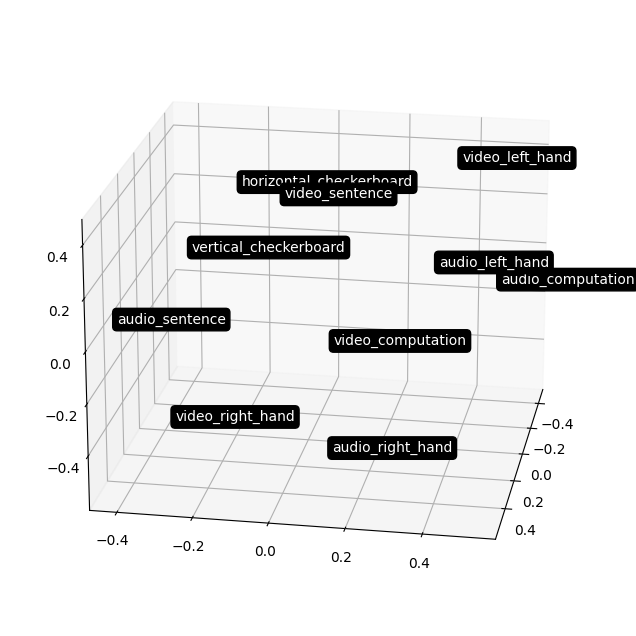

In [27]:
f = rsa[roi].plot_mds(n_components=3,view=(20, 10))

Let's switch this from a distance matrix to a similarity matrix. Since we used correlation distance above, we can simply subtract the distance values from 1 to get similarity.

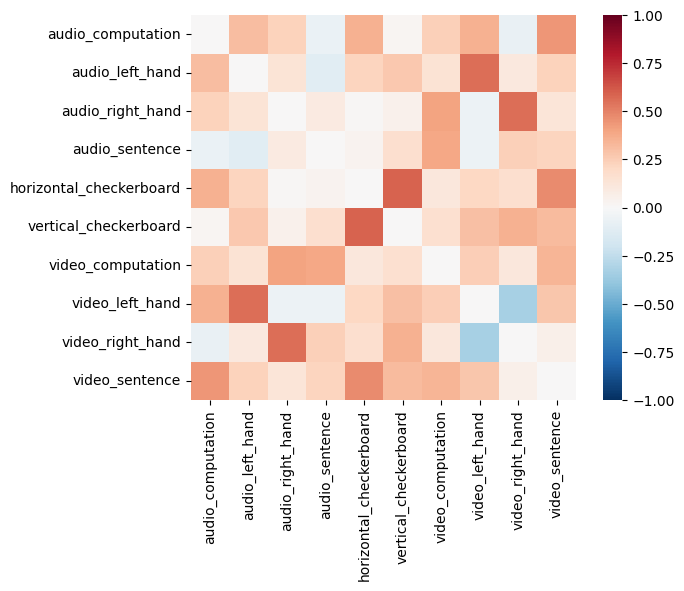

In [60]:
rsa_sim = []
for m in rsa:
    mask_tmp = m.copy()
    mask_tmp = 1 - mask_tmp
    mask_tmp.labels = conditions
    rsa_sim.append(mask_tmp)
rsa_sim[roi].plot(vmin=-1, vmax=1, cmap='RdBu_r')

## Testing a representation hypothesis

We can easily compare the neural similarity/distance measures to hypothesized relationships. For example, let's test the hypothesis that motor responses whether cued by auditory or video stimuli will show similar patterns. We can construct this hypothesis with the following matrix:

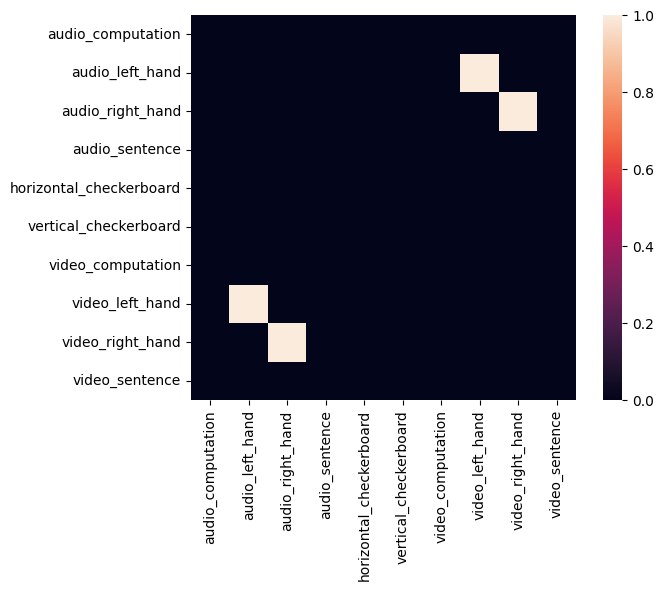

In [57]:
motor = np.zeros((len(conditions),len(conditions)))
motor[np.diag_indices(len(conditions))] = 1 
motor[1,7] = 1
motor[7,1] = 1
motor[2,8] = 1
motor[8,2] = 1
motor = Adjacency(motor, matrix_type='distance', labels=conditions)
motor.plot()

Next, we can search over all the ROIs to quantify how well the neural representations match this hypothesis. `Adjacency` has a `similarity()` method that measures the similarity between two `Adjacency` instance using, by default, Spearman correlation (there are other options, of course). Note, the `similarity()` method includes an option to perform permutation testing, in fact it does this by default. This takes time, of course, so for now we can set this to 0.

In [63]:
motor_sim_r = []
for m in rsa_sim:
    s = m.similarity(motor, metric='spearman', n_permute=0)
    motor_sim_r.append(s['correlation'])

{'correlation': 0.21587854946759213, 'p': 1.0}

In [66]:
rsa_motor = roi_to_brain(motor_sim_r, mask_x)
rsa_motor.iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

We can see that motor cortex exhibits similar neural patterns for finger tapping regardless of the cueing modality (same across video and audio). 

This is evidence from only one participant. Extending this analysis across the group would require re-running this RSA on all participants, aggregating the results for the ROIs (dont' forget about Fisher r to z transformations, which is a method (`r_to_z()`) of `Adjacency` instances!), and performing statistical tests that quantify whether or not the relationship between neural and hypothesized representation is significant.

This is a simple analysis on simple data, but hopefully demonstrates how easy it is to conduct RSA with nltools.